In [4]:
import seaborn as sns

In [5]:
import newBlock as nb
import pandas as pd
import xarray as xr
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data_ = xr.open_dataset('D:/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/Climatologias/nc/ver_inv_500hPa.nc')
data_

<xarray.Dataset>
Dimensions:    (latitude: 61, longitude: 81, time: 29160)
Coordinates:
  * longitude  (longitude) float32 -60.0 -59.75 -59.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 -10.0 -10.25 -10.5 ... -24.5 -24.75 -25.0
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T18:00:00
Data variables:
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-06-19 17:01:33 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [7]:
data_.v.attrs

{'units': 'm s**-1',
 'long_name': 'V component of wind',
 'standard_name': 'northward_wind'}

In [8]:
adapt = data_.resample(time='D').mean()

In [9]:
adapt.u.attrs.update({'units': 'm s**-1', 'long_name': 'U component of wind','standard_name': 'eastward_wind'})
adapt.v.attrs.update({'units': 'm s**-1', 'long_name': 'V component of wind','standard_name': 'northward_wind'})

In [10]:
uwnd = adapt.drop('v')
vwnd = adapt.drop('u')

In [11]:
uwnd = nb.dataset(uwnd.to_netcdf(),'ERA-5')
vwnd = nb.dataset(vwnd.to_netcdf(),'ERA-5')

In [ ]:
u79 = nb.dataset("uwnd.d.mean.850.nc", "NCEP")
u89 = nb.dataset("uwnd.d.mean.850.2.nc", "NCEP")
u99 = nb.dataset("uwnd.d.mean.850.3.nc", "NCEP")
u09 = nb.dataset("uwnd.d.mean.850.4.nc", "NCEP")
ulist = [u79, u89, u99, u09]
form = []
for u in ulist:
    form.append(u.formatar().dataset)
u = xr.concat(form, dim='time')
uwnd = nb.dataset(u.to_netcdf(), "NCEP")

In [4]:
v79 = nb.dataset("vwnd.d.mean.850.1.nc", "NCEP")
v89 = nb.dataset("vwnd.d.mean.850.2.nc", "NCEP")
v99 = nb.dataset("vwnd.d.mean.850.3.nc", "NCEP")
v09 = nb.dataset("vwnd.d.mean.850.4.nc", "NCEP")
vlist = [v79, v89, v99, v09]
form = []
for v in vlist:
    form.append(v.formatar().dataset)
v = xr.concat(form, dim='time')
vwndteste = nb.dataset(v.to_netcdf(), "NCEP")

/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/xarray/conventions.py:417: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


In [4]:
u792 = nb.dataset("uwnd.500.1.nc", "NCEP")
u892 = nb.dataset("uwnd.500.2.nc", "NCEP")
u992 = nb.dataset("uwnd.500.4.nc", "NCEP")
u092 = nb.dataset("uwnd.500.3.3.nc", "NCEP")
ulist = [u792, u892, u992, u092]
#print(ulist)
form = []
for u in ulist:
    form.append(u.formatar().dataset)
u2 = xr.concat(form, dim='time')
uwnd2 = nb.dataset(u2.to_netcdf(), "NCEP")

/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/xarray/conventions.py:417: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


In [5]:
v792 = nb.dataset("vwnd.500.1.nc", "NCEP")
v892 = nb.dataset("vwnd.500.2.nc", "NCEP")
v992 = nb.dataset("vwnd.500.3.nc", "NCEP")
v092 = nb.dataset("vwnd.500.4.nc", "NCEP")
vlist = [v792, v892, v992, v092]
#print(vlist)
form = []
for v in vlist:
    form.append(v.formatar().dataset)
v2 = xr.concat(form, dim='time')
vwnd2 = nb.dataset(v2.to_netcdf(), "NCEP")

/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/xarray/conventions.py:417: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(


# Índice de bloqueios

In [12]:
def posix(datasets, bloq = 'continuo', freq='D'):
    #recebe uma lista de objetos lammoc_medias (vorticidade ou divergência, pro bloqueio) já recortados 
    #retorna um dataset com o formato dim = tempo, data = indice de bloqueio
    da = []
    if type(datasets) != list:
        datasets = [datasets]
    for ds in datasets:
        
        start = pd.to_datetime(ds.dataset.time.values[0])
        end = pd.to_datetime(ds.dataset.time.values[-1])
        latitudes = [ds.dataset.lat.values[0], ds.dataset.lat.values[-1]]
        longitudes = [ds.dataset.lon.values[0], ds.dataset.lon.values[-1]]
        
        #só pra pegar o nome da variável
        ext_name = ds.dataset.to_array().isel(variable=0)
        var = str(ext_name['variable'].values)
        
        #tira a média regional e dropa os valores negativos do dataset e tira o índice de bloqueios
        med = ds.media_regional()
        dropped = med.dataset.where(med.dataset[var]>0, drop=True)
        bloqueio = 0 #contador de dias de bloqueio
        bloqueios = {} #dicionário para armazenar o contador de bloqueios e o dia da contagem
        #o loop a seguir enumera os valores remanescentes (os que possuem valor de vorticidade ou divergência positivos).
        for ix, dia in enumerate(pd.to_datetime(dropped.time.values)):
            aux = dropped.sel(time=dia) #cortando diariamente 
            #caso o dia seja o primeiro, já se contabiliza um dia de valor positivo, pois o dataset já está recortado para
            #valores positivos
            if ix == 0:
                count = 1
            else:
                #se o dia for igual ao dia anterior + 1, ou seja, se for o dia seguinte ao dia de valor positivo,
                #o count armazena que houve mais um dia de possível bloqueio. 
                if (dia == pd.to_datetime(dropped.time.values[ix-1]) + datetime.timedelta(days = 1)) and (dia.day != 1):
                    count += 1
                    #print('ant:', pd.to_datetime(dropped.time.values[ix-1]).day, pd.to_datetime(dropped.time.values[ix-1]).month, 'dia:', dia.day, dia.month, "cont:", count)
                    #Quando o contador supera 3 dias seguidos:
                    #a variável bloqueio armazena 1 dia de bloqueio; 
                    #caso continue contabilizando valores positivos, a variável de bloqueio vai contando esses dias
                    if count >= 3:
                        bloqueio += 1
                        #o armazenamento acontece da seguinte forma: dia1 = 1, dia2 = 2, dia3 = 3, etc...
                        #o parâmetro bloq define se o usuário deseja a contagem dia por dia, ou apenas que seja
                        #retornado o número total de dias de bloqueio, ou seja: dia1 = 0, dia2 = 0, dia3 = 3
                        if bloq == 'total':
                            bloqueios.update({dia-datetime.timedelta(days = 1): 0})
                        bloqueios.update({dia: bloqueio})
                else:
                    count = 0
                    bloqueio = 0
        da.append(xr.DataArray(list(bloqueios.values()), coords=[list(bloqueios.keys())], dims=['time'], name=var))
    ds = xr.merge(da)
    ds = ds.reindex({"time": pd.date_range(start=start, end=end, freq='D')})

    if freq == 'D':
        ds.attrs['lat'] = str(latitudes[0]) + ":" + str(latitudes[1])
        ds.attrs['lon'] = str(longitudes[0]) + ":" + str(longitudes[1])
        return ds
    elif freq == 'M' and bloq == 'total':
        ds = ds.resample(time='MS').sum()
        ds.attrs['lat'] = str(latitudes[0]) + ":" + str(latitudes[1])
        ds.attrs['lon'] = str(longitudes[0]) + ":" + str(longitudes[1])
        return ds
    elif freq == 'season' and bloq == 'total':
        ds = ds.resample(time='QS-DEC').sum()
        ds.attrs['lat'] = str(latitudes[0]) + ":" + str(latitudes[1])
        ds.attrs['lon'] = str(longitudes[0]) + ":" + str(longitudes[1])
        return ds

In [13]:
def blockix(ds, bloq='continuo', freq='D'):
    bloqueios = {}
    positivos = posix([ds[0], ds[1]])
    datas = positivos.dropna(dim='time', how='any')
    #print(positivos)
    #print(datas)
    count = 1
    for ix, dia in enumerate(pd.to_datetime(datas.time.values)):
        if (dia == pd.to_datetime(datas.time.values[ix-1]) + datetime.timedelta(days = 1)) and (dia.day != 1):
            count += 1
            #print(dia)
            bloqueios.update({dia: count})
            if bloq == 'total':
                bloqueios.update({dia-datetime.timedelta(days = 1): 0})
            elif bloq == 'continuo':
                bloqueios.update({dia-datetime.timedelta(days = 1): count-1})
        else:
            count = 1
    indice = xr.DataArray(list(bloqueios.values()), coords=[list(bloqueios.keys())], dims=['time'], name='índice de bloqueios')
    indice = indice.reindex({"time": pd.date_range(start=positivos.time.values[0], end=positivos.time.values[-1], freq='D')})
    indice = indice.to_dataset()
    if freq == 'D':
        return indice
    elif freq == 'M' and bloq == 'total':
        indice = indice.resample(time='MS').sum()
        return indice
    elif freq == 'season' and bloq == 'total':
        indice = indice.resample(time='QS-DEC').sum()
        return indice

# Vazão

In [14]:
def vazoes(regiao = 'todas'):
    vazoes = pd.read_csv("D:/_Gabriel/Estudo/UFF/Bloqueios_Atmosfericos/vazoesdiarias.csv", sep=";", header=5, index_col=0, decimal = ',', low_memory=False)
    vazoes.index = pd.to_datetime(vazoes.index, errors='coerce')
    vazoes_br = vazoes.loc['1979-01-01' : '2019-01-01', ['246', '34', '237', '240', '33', '24', '6', '18', '156', '168', '275', '287', '285', '190', '254']]
    vazoes_br = vazoes_br.apply(pd.to_numeric, errors='ignore')
    vazoes_sul = vazoes.loc['1979-01-01' : '2019-01-01', ['111', '217', '74', '78', '66', '63', '61']]
    vazoes_sul = vazoes_sul.apply(pd.to_numeric, errors='ignore')
    br = xr.Dataset.from_dataframe(vazoes_br)
    br = br.rename({'index': 'time'})
    br = br.sortby('time')
    sul = xr.Dataset.from_dataframe(vazoes_sul)
    sul = sul.rename({'index': 'time'})
    sul = sul.sortby('time')
    if regiao == 'todas':
        return br, sul
    if regiao == 'sul':
        return sul
    if regiao == 'br':
        return br

In [15]:
def normalizar(ds):
    minimum = []
    maximum = []
    for index in ds.data_vars:
        minimum.append(ds.data_vars[index].values.min())
        maximum.append(ds.data_vars[index].values.max())
        datamin = np.min(minimum)
        datamax = np.max(maximum)
    norm = (ds-datamin)/(datamax-datamin)
    return norm

In [16]:
def vazcorrs(atmds, regiao, season):
    indice = blockix([atmds[0], atmds[1]], bloq='total', freq='season')
    teste = posix([atmds[0], atmds[1]], bloq='total', freq='season')
    vaz = vazoes(regiao=regiao).sel(time=slice(pd.to_datetime(indice.time.values[0]), pd.to_datetime(indice.time.values[-1])))
    normvaz = normalizar(vaz.resample(time='QS-DEC').mean()).to_dataframe()
    df = normvaz.join([indice.to_dataframe(), teste.to_dataframe()])
    df.fillna(0, inplace=True)
    if season == "DJF":
        df = df[df.index.month==12]
    if season == "MAM":
        df = df[df.index.month==3]
    if season == "JJA":
        df = df[df.index.month==6]
    if season == "SON":
        df = df[df.index.month==9]
    df = df.drop('div',axis=1)
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    mask
    #corr = plt.figure(figsize=(15,15))
    #corr = sns.heatmap(df.corr(), annot=True, cmap='RdBu', mask=mask, vmin=-1, vmax=1, center = 0)
    #corr.set_title('Bloqueios (' + teste.attrs['lat'] + '-' + teste.attrs['lon'] + '; 500hPa) x Bacias: ' + regiao.upper() + ' (' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '-' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + ': ' + season + ')')
    
    #plt.savefig('corr500' + teste.attrs['lat'] + '_' + teste.attrs['lon'] + regiao + '_' + season + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + '.png')

    #return df
    #if cov == True:
    #    cov = plt.figure(figsize=(15,15))
    #    cov = sns.heatmap(df.cov(), annot=True, cmap='RdBu')

In [81]:
div = uwnd.formatar(data_2=vwnd, lat = latitude, time = periodo, opr='divergência')
vort = uwnd.formatar(data_2=vwnd, lat = latitude, time = periodo, opr='vorticidade')
atmds = [vort, div]
regiao = 'br'
season = 'DJF'
indice = blockix([atmds[0], atmds[1]], bloq='total', freq='season')
teste = posix([atmds[0], atmds[1]], bloq='total', freq='season')
vaz = vazoes(regiao=regiao).sel(time=slice(pd.to_datetime(indice.time.values[0]), pd.to_datetime(indice.time.values[-1])))
normvaz = normalizar(vaz.resample(time='QS-DEC').mean()).to_dataframe()
df = normvaz.join([indice.to_dataframe(), teste.to_dataframe()])
df.fillna(0, inplace=True)
if season == "DJF":
    df = df[df.index.month==12]
if season == "MAM":
    df = df[df.index.month==3]
if season == "JJA":
    df = df[df.index.month==6]
if season == "SON":
    df = df[df.index.month==9]
df


C:\Users\Gabriel\miniconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


,246,34,237,240,33,24,6,18,156,168,275,287,285,190,254,índice de bloqueios,vort,div
time,,,,,,,,,,,,,,,,,,
2009-12-01,0.321466,0.210681,0.029434,0.044567,0.087825,0.013634,0.033324,0.084513,0.017339,0.044929,0.358351,0.653499,0.647506,0.011941,0.000603,0.0,9.0,4.0
2010-12-01,0.289044,0.197581,0.021381,0.035640,0.082155,0.015222,0.040592,0.084593,0.022431,0.054701,0.368241,0.511423,0.508360,0.012801,0.001788,0.0,24.0,2.0
2011-12-01,0.280028,0.207218,0.017657,0.029259,0.094837,0.021625,0.037916,0.081281,0.037290,0.063239,0.448741,0.527034,0.524198,0.011998,0.000700,2.0,27.0,9.0
2012-12-01,0.232358,0.159791,0.017910,0.028557,0.065838,0.012488,0.032299,0.068182,0.015316,0.037207,0.299681,0.555306,0.553763,0.013866,0.000667,2.0,20.0,13.0
2013-12-01,0.162536,0.113551,0.007432,0.013466,0.058713,0.011811,0.013498,0.036298,0.011090,0.041461,0.366110,0.807024,0.799279,0.012017,0.003779,0.0,10.0,6.0
2014-12-01,0.168300,0.109685,0.010856,0.017239,0.052387,0.008863,0.010932,0.033423,0.007855,0.030302,0.258000,0.695302,0.689866,0.010406,0.002962,0.0,12.0,9.0
2015-12-01,0.262506,0.166650,0.021144,0.036514,0.065172,0.011121,0.028203,0.073972,0.015600,0.035200,0.192342,0.479709,0.475144,0.011173,0.005621,0.0,24.0,19.0
2016-12-01,0.207202,0.130919,0.016126,0.026026,0.050102,0.007537,0.015608,0.049671,0.009572,0.015992,0.223639,0.466592,0.463462,0.010059,0.000000,0.0,34.0,0.0
2017-12-01,0.215227,0.137708,0.012142,0.019061,0.058913,0.008879,0.014440,0.048172,0.010435,0.024457,0.317167,0.679274,0.672361,0.010450,0.000278,3.0,55.0,6.0


In [83]:
div = uwnd.formatar(data_2=vwnd, lat = latitude, time = periodo, opr='divergência')
vort = uwnd.formatar(data_2=vwnd, lat = latitude, time = periodo, opr='vorticidade')
atmds = [vort, div]
regiao = 'sul'
season = 'DJF'
indice = blockix([atmds[0], atmds[1]], bloq='total', freq='season')
teste = posix([atmds[0], atmds[1]], bloq='total', freq='season')
vaz = vazoes(regiao=regiao).sel(time=slice(pd.to_datetime(indice.time.values[0]), pd.to_datetime(indice.time.values[-1])))
normvaz = normalizar(vaz.resample(time='QS-DEC').mean()).to_dataframe()
df2 = normvaz.join([indice.to_dataframe(), teste.to_dataframe()])
df2.fillna(0, inplace=True)
if season == "DJF":
    df2 = df2[df2.index.month==12]
if season == "MAM":
    df2 = df2[df2.index.month==3]
if season == "JJA":
    df2 = df2[df2.index.month==6]
if season == "SON":
    df2 = df2[df2.index.month==9]
df2


C:\Users\Gabriel\miniconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


,111,217,74,78,66,63,61,índice de bloqueios,vort,div
time,,,,,,,,,,
2009-12-01,0.011444,0.047633,0.045467,0.071634,0.828482,0.117274,0.110751,0.0,9.0,4.0
2010-12-01,0.005352,0.058005,0.063442,0.095714,0.743297,0.088967,0.080186,0.0,24.0,2.0
2011-12-01,0.000952,0.024346,0.027613,0.042545,0.630674,0.055441,0.049803,2.0,27.0,9.0
2012-12-01,0.006249,0.019412,0.024272,0.045807,0.605985,0.074286,0.062879,2.0,20.0,13.0
2013-12-01,0.006287,0.037062,0.028474,0.052326,0.436896,0.049184,0.041761,0.0,10.0,6.0
2014-12-01,0.008739,0.043742,0.037773,0.060551,0.506983,0.068043,0.059654,0.0,12.0,9.0
2015-12-01,0.015061,0.035670,0.049226,0.082518,0.896064,0.162752,0.141721,0.0,24.0,19.0
2016-12-01,0.006754,0.028188,0.030999,0.053438,0.590985,0.083306,0.073902,0.0,34.0,0.0
2017-12-01,0.008436,0.027721,0.027232,0.051615,0.704129,0.097791,0.086578,3.0,55.0,6.0


In [85]:
lis_DF = pd.merge(df,df2)
lis_DF.to_csv('tomaLis.csv')

In [ ]:
seasons = ['DJF', 'JJA']#, 'MAM', 'JJA', 'SON']
regioes = ['br', 'sul']
periodos = [['1979-01-01', '2010-12-01'], ['2010-01-01', '2018-12-01']]
latitudes = [[-10, -25], [-17.5, -25], [-10,-17.5]]
for periodo in periodos:
    for latitude in latitudes:
        div = uwnd.formatar(data_2=vwnd, lat = latitude, time = periodo, opr='divergência')
        vort = uwnd.formatar(data_2=vwnd, lat = latitude, time = periodo, opr='vorticidade')
        for regiao in regioes:
            for season in seasons:
                df = vazcorrs([vort, div], regiao, season)

C:\Users\Gabriel\miniconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\Gabriel\miniconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\Gabriel\miniconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\Gabriel\miniconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# ZCAS

In [7]:
import pandas as pd

In [8]:
def zcas(freq='D'):
    zcasexcel = pd.read_excel("zcas.xlsx", sep=";", header=1, index_col=0, decimal = ',')  
    zcas = pd.DataFrame(zcasexcel['SUDESTE'].values, index = zcasexcel.index, columns=['zcas'])
    zcas.replace('zcas', 1, inplace=True)
    if freq == 'M':
        zcas = zcas.resample('MS').sum()
    if freq == "season":
        zcas = zcas.resample("QS-DEC").sum()
    reczcas = pd.concat([zcas[zcas.index.month <= 4], zcas[zcas.index.month >= 10]]).sort_index()
    return reczcas

In [50]:
zcas('M').index[0].year

1995

In [9]:
def zcascorrs(atmds):
    ZCAS = zcas(freq='M')
    indice = blockix([atmds[0], atmds[1]], bloq='total', freq='M')
    #indice = indice.sel(time=slice(ZCAS.index.values[0], ZCAS.index.values[-1]))
    teste = posix([atmds[0], atmds[1]], bloq='total', freq='M')
    #print(indice.to_dataframe())
    df = ZCAS.join([indice.to_dataframe(), teste.to_dataframe()]).dropna()
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    corr = plt.figure(figsize=(15,15))
    corr = sns.heatmap(df.corr(), annot=True, mask = mask, cmap='RdBu', vmin=-1, vmax=1, center = 0)
    corr.set_title('Bloqueios (' + teste.attrs['lat'] + '-' + teste.attrs['lon'] + '; 500hPa) x ZCAS (' + str(df.index[0].year) + '-' + str(df.index[-1].year) + ')')
    #plt.savefig('corr850' + teste.attrs['lat'] + '-' + teste.attrs['lon'] + '_ZCAS_' + str(df.index[0].year) + '-' + str(df.index[-1].year) + '.png', format='png')
    #return df

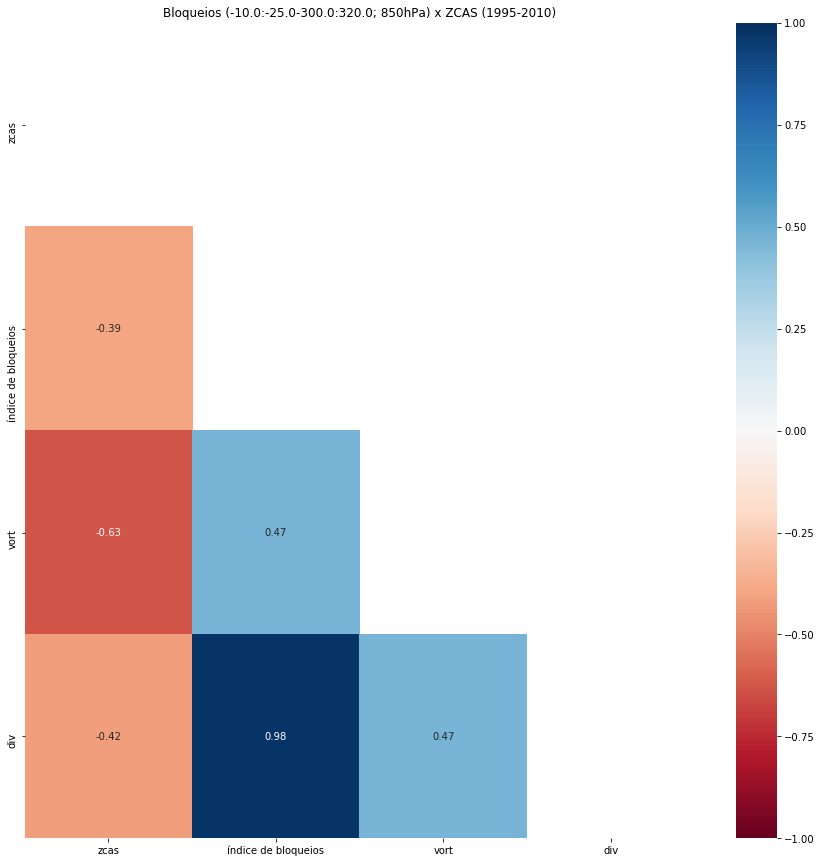

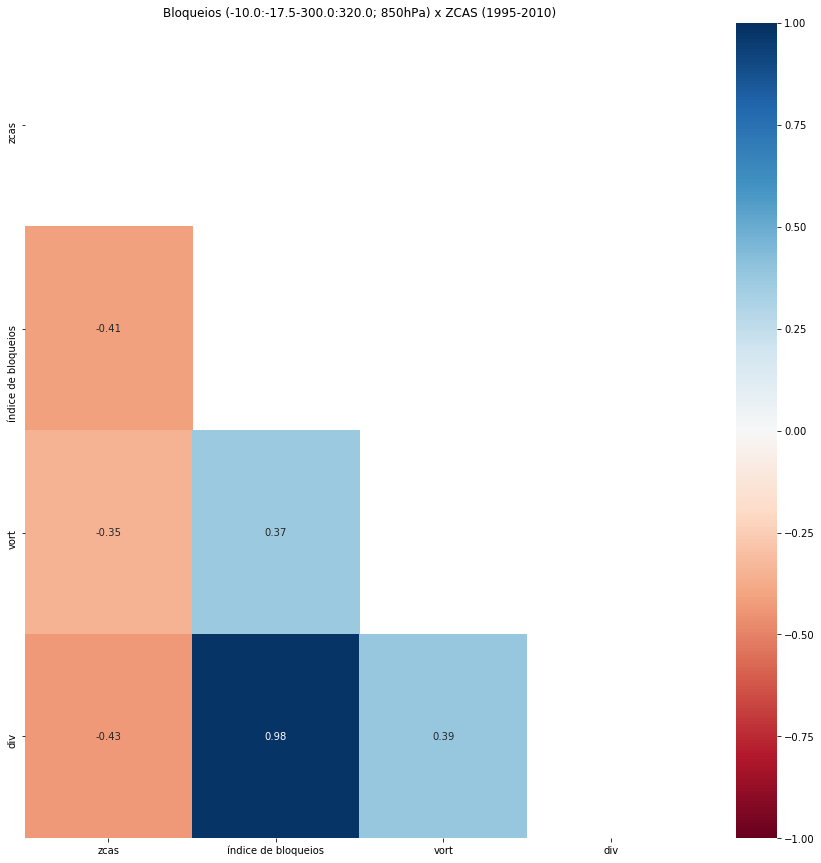

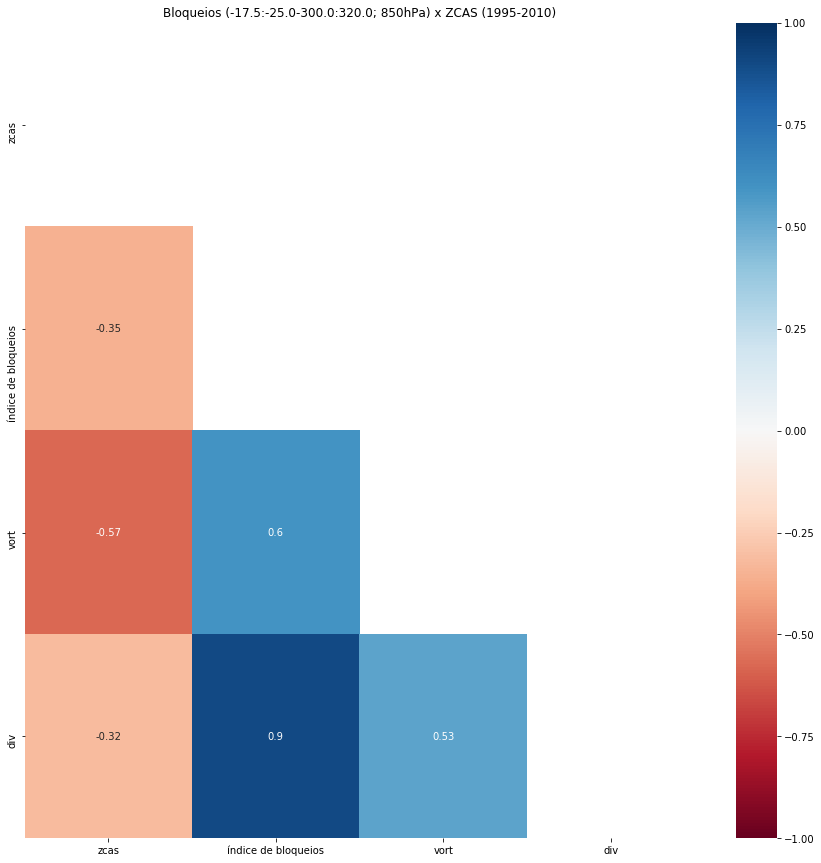

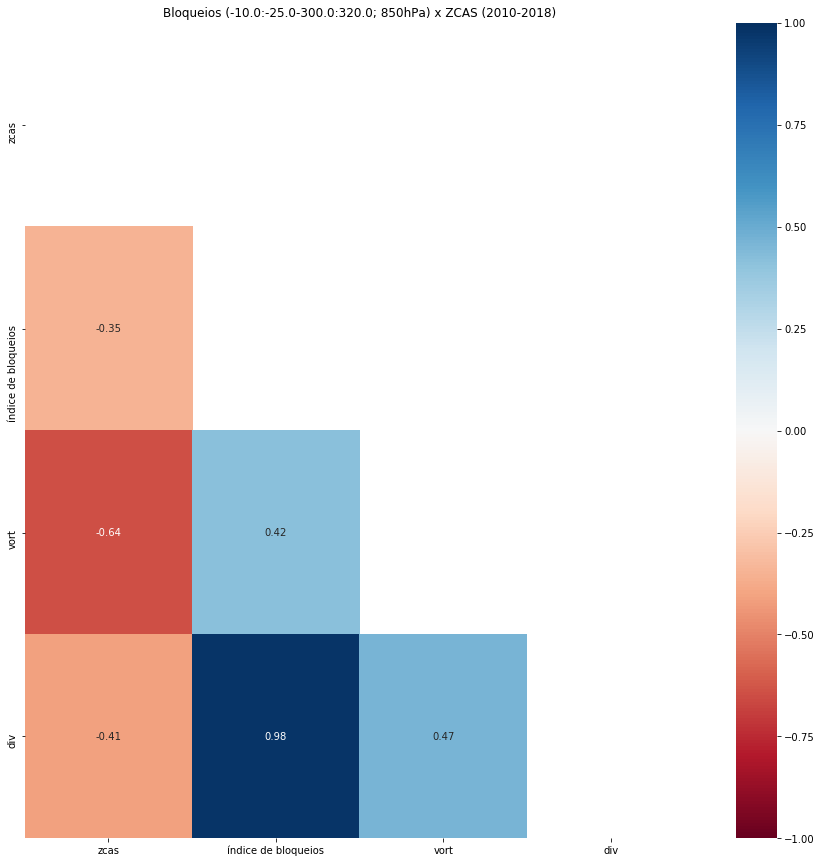

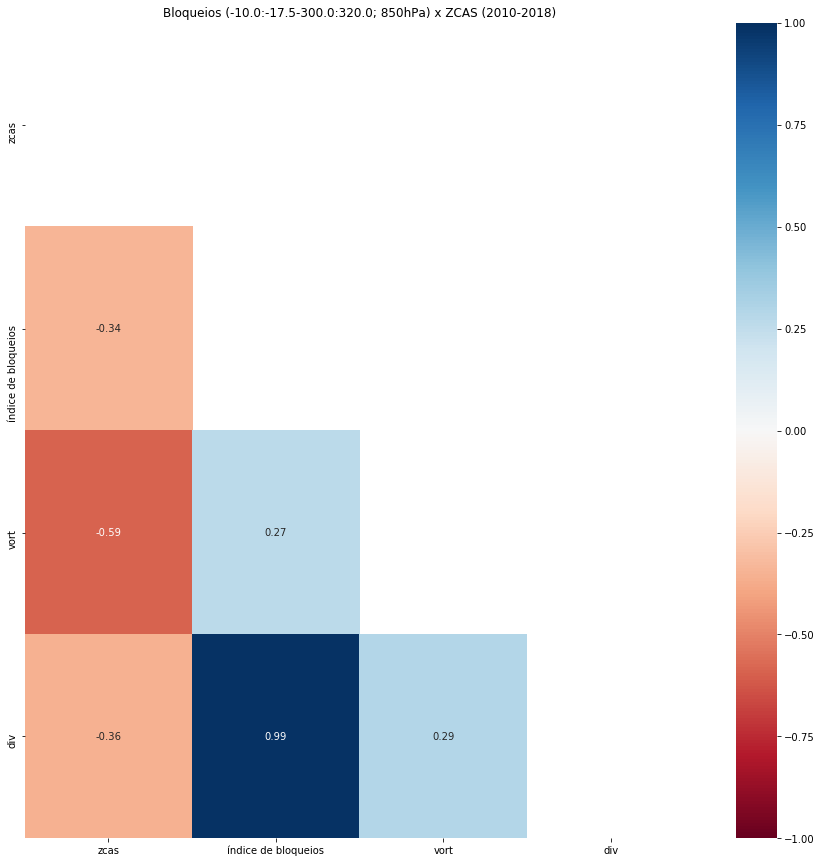

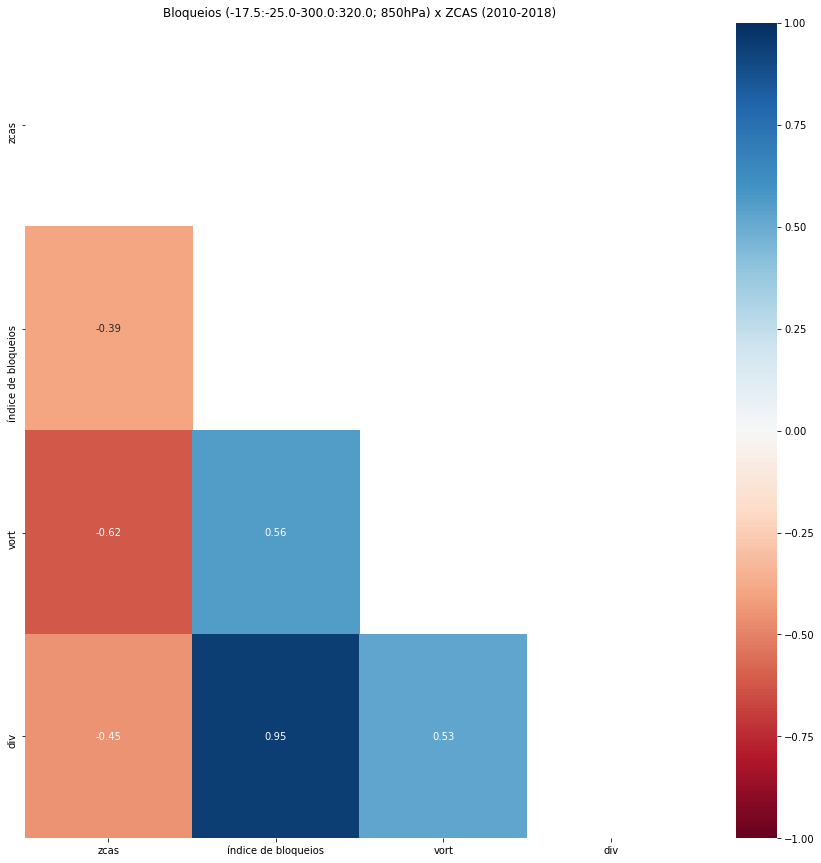

In [10]:
periodos = [['1979-01-01', '2010-12-01'], ['2010-01-01', '2018-12-01']]
latitudes = [[-10, -25], [-10, -17.5], [-17.5, -25]]
for periodo in periodos:
    for latitude in latitudes:
        div = uwnd.formatar(data_2=vwnd, lat = latitude, lon = [300, 320], time = periodo, level=500, opr='divergência')
        vort = uwnd.formatar(data_2=vwnd, lat = latitude, lon = [300, 320], time = periodo, level=500, opr='vorticidade')
        #for regiao in regioes:
        df = zcascorrs([vort, div])

In [43]:
df.corr()

,zcas,índice de bloqueios,vort,div
zcas,1.000000,-0.392787,-0.630987,-0.416219
índice de bloqueios,-0.392787,1.000000,0.465488,0.977887
vort,-0.630987,0.465488,1.000000,0.468591
div,-0.416219,0.977887,0.468591,1.000000


In [86]:
indice = blockix([vort, div], bloq='total', freq='M')

In [93]:
z = zcas('M')

In [104]:
str(z.index.values[0])

'1995-12-31T00:00:00.000000000'

In [90]:
indice.to_dataframe()

,índice de bloqueios
time,
1979-01-01,0.0
1979-02-01,2.0
1979-03-01,3.0
1979-04-01,11.0
1979-05-01,11.0
...,...
2010-08-01,20.0
2010-09-01,2.0
2010-10-01,0.0
